In [1]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from scipy.stats import skew, kurtosis, normaltest
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error,roc_auc_score,precision_score, recall_score,accuracy_score
from sklearn.ensemble import RandomForestRegressor
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction import DictVectorizer

In [2]:
!wget -O ./data/car_fuel_efficiency.csv wget https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv

Prepended http:// to 'wget'
--2025-11-03 23:58:19--  http://wget/
Resolving wget (wget)... failed: nodename nor servname provided, or not known.
wget: unable to resolve host address ‘wget’
--2025-11-03 23:58:19--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/car_fuel_efficiency.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.108.133, 185.199.109.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 874188 (854K) [text/plain]
Saving to: ‘./data/car_fuel_efficiency.csv’

./data/car_fuel_eff 100%[===================>] 853.70K  --.-KB/s    in 0.03s   

2025-11-03 23:58:19 (31.0 MB/s) - ‘./data/car_fuel_efficiency.csv’ saved [874188/874188]

FINISHED --2025-11-03 23:58:19--
Total wall clock time: 0.3s
Downloaded: 1 files, 854K in 0.03s (31.0 MB/s)


In [3]:
df = pd.read_csv("./data/car_fuel_efficiency.csv")

In [4]:
print("Original:")
for column in df.columns:
    print(f"{column} missing {df[column].isnull().sum()} records")

df_filled = df.copy()

df_filled['num_cylinders'] = df['num_cylinders'].fillna(0)
df_filled['horsepower'] = df['horsepower'].fillna(0)
df_filled['num_doors'] = df['num_doors'].fillna(0)
df_filled['acceleration'] = df['acceleration'].fillna(0)

print("Filled:")
for column in df.columns:
    print(f"{column} missing {df_filled[column].isnull().sum()} records")

Original:
engine_displacement missing 0 records
num_cylinders missing 482 records
horsepower missing 708 records
vehicle_weight missing 0 records
acceleration missing 930 records
model_year missing 0 records
origin missing 0 records
fuel_type missing 0 records
drivetrain missing 0 records
num_doors missing 502 records
fuel_efficiency_mpg missing 0 records
Filled:
engine_displacement missing 0 records
num_cylinders missing 0 records
horsepower missing 0 records
vehicle_weight missing 0 records
acceleration missing 0 records
model_year missing 0 records
origin missing 0 records
fuel_type missing 0 records
drivetrain missing 0 records
num_doors missing 0 records
fuel_efficiency_mpg missing 0 records


In [5]:
y = df['fuel_efficiency_mpg']
X = df.drop(columns=['fuel_efficiency_mpg'])


X_train, X_temp, y_train, y_temp = train_test_split(
    X, y, test_size=0.4, random_state=1
)

X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=1
)


print(f"df_train: {len(X_train)} rows")
print(f"df_val:   {len(X_val)} rows")
print(f"df_test:  {len(X_test)} rows")

df_train: 5822 rows
df_val:   1941 rows
df_test:  1941 rows


In [6]:
X_train.head()

,engine_displacement,num_cylinders,horsepower,vehicle_weight,acceleration,model_year,origin,fuel_type,drivetrain,num_doors
4150,150,5.0,NaN,2510.410896,10.0,2010,Europe,Gasoline,Front-wheel drive,0.0
5660,200,3.0,181.0,3597.483663,12.7,2006,Europe,Diesel,Front-wheel drive,0.0
7319,220,6.0,118.0,2217.349625,NaN,2004,USA,Diesel,All-wheel drive,-2.0
1562,110,3.0,136.0,3307.407159,15.9,2010,USA,Gasoline,All-wheel drive,-2.0
7499,220,2.0,190.0,3315.299773,18.3,2017,USA,Diesel,Front-wheel drive,1.0


In [7]:
y = df["fuel_efficiency_mpg"].values
X_train_dicts = X_train.to_dict(orient="records")
X_val_dicts   = X_val.to_dict(orient="records")
X_test_dicts  = X_test.to_dict(orient="records")

dv = DictVectorizer(sparse=False)
X_train_enc = dv.fit_transform(X_train_dicts)
X_val_enc   = dv.transform(X_val_dicts)
X_test_enc  = dv.transform(X_test_dicts)


In [8]:
dv.get_feature_names_out()

array(['acceleration', 'drivetrain=All-wheel drive',
       'drivetrain=Front-wheel drive', 'engine_displacement',
       'fuel_type=Diesel', 'fuel_type=Gasoline', 'horsepower',
       'model_year', 'num_cylinders', 'num_doors', 'origin=Asia',
       'origin=Europe', 'origin=USA', 'vehicle_weight'], dtype=object)

### Question 1

In [9]:
dt = DecisionTreeRegressor(max_depth=1)
dt.fit(X_train_enc, y_train)

y_pred = dt.predict(X_val_enc)
print(mean_squared_error(y_val, y_pred))

2.5399474400882105


In [10]:
from sklearn.tree import export_text
print(export_text(dt, feature_names=dv.get_feature_names_out()))

|--- vehicle_weight <= 3028.82
|   |--- value: [16.86]
|--- vehicle_weight >  3028.82
|   |--- value: [12.87]



### Question 2

In [11]:
rf = RandomForestRegressor(n_estimators=10, random_state=1)
rf.fit(X_train_enc, y_train)

y_pred = rf.predict(X_val_enc)
print(mean_squared_error(y_val, y_pred))


0.2034652164173224


### Question 3

In [12]:
for n in range(10, 201, 10):
    rf = RandomForestRegressor(n_estimators=n, random_state=1, n_jobs=-1)
    rf.fit(X_train_enc, y_train)

    y_pred = rf.predict(X_val_enc)
    print(f"Step:{n} | Score: {mean_squared_error(y_val, y_pred):.3f}")

Step:10 | Score: 0.203
Step:20 | Score: 0.192
Step:30 | Score: 0.188
Step:40 | Score: 0.186
Step:50 | Score: 0.184
Step:60 | Score: 0.183
Step:70 | Score: 0.184
Step:80 | Score: 0.184
Step:90 | Score: 0.184
Step:100 | Score: 0.184
Step:110 | Score: 0.184
Step:120 | Score: 0.183
Step:130 | Score: 0.183
Step:140 | Score: 0.183
Step:150 | Score: 0.183
Step:160 | Score: 0.183
Step:170 | Score: 0.183
Step:180 | Score: 0.183
Step:190 | Score: 0.183
Step:200 | Score: 0.183


### Question 4

Depth:10 | Step:10 | Score: 0.193
Depth:10 | Step:20 | Score: 0.185
Depth:10 | Step:30 | Score: 0.182
Depth:10 | Step:40 | Score: 0.181
Depth:10 | Step:50 | Score: 0.180
Depth:10 | Step:60 | Score: 0.179
Depth:10 | Step:70 | Score: 0.179
Depth:10 | Step:80 | Score: 0.179
Depth:10 | Step:90 | Score: 0.179
Depth:10 | Step:100 | Score: 0.179
Depth:10 | Step:110 | Score: 0.180
Depth:10 | Step:120 | Score: 0.180
Depth:10 | Step:130 | Score: 0.179
Depth:10 | Step:140 | Score: 0.179
Depth:10 | Step:150 | Score: 0.179
Depth:10 | Step:160 | Score: 0.179
Depth:10 | Step:170 | Score: 0.179
Depth:10 | Step:180 | Score: 0.179
Depth:10 | Step:190 | Score: 0.179
Depth:10 | Step:200 | Score: 0.179
Depth:15 | Step:10 | Score: 0.206
Depth:15 | Step:20 | Score: 0.193
Depth:15 | Step:30 | Score: 0.188
Depth:15 | Step:40 | Score: 0.185
Depth:15 | Step:50 | Score: 0.184
Depth:15 | Step:60 | Score: 0.183
Depth:15 | Step:70 | Score: 0.183
Depth:15 | Step:80 | Score: 0.183
Depth:15 | Step:90 | Score: 0.183
Dep

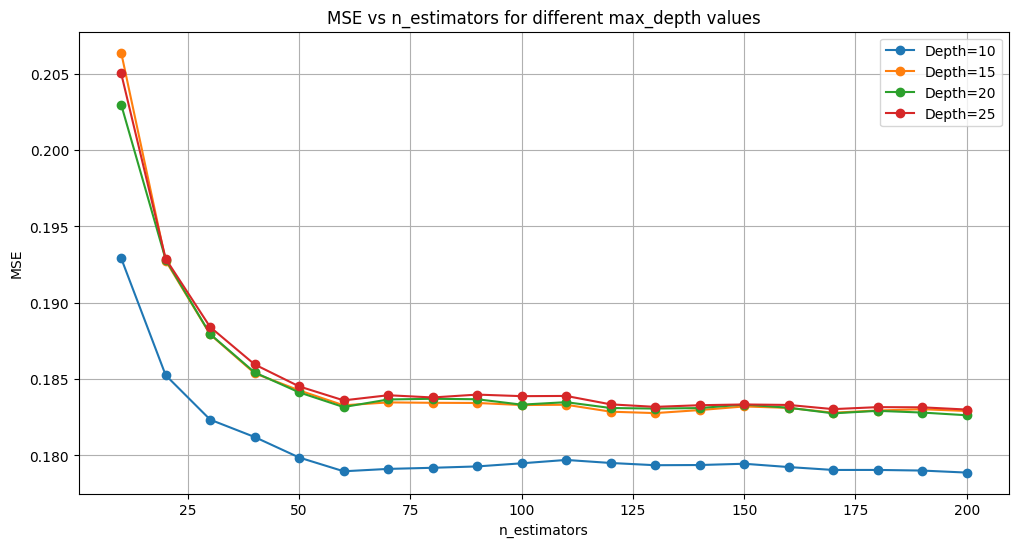

In [13]:
best_params = {'max_depth': None, 'n_estimators': None, 'mse': float('inf')}
results = []

for i in [10,15,20,25]:
    for n in range(10, 201, 10):
        rf = RandomForestRegressor(n_estimators=n, max_depth=i, random_state=1, n_jobs=-1)
        rf.fit(X_train_enc, y_train)

        y_pred = rf.predict(X_val_enc)
        mse = mean_squared_error(y_val, y_pred)
        print(f"Depth:{i} | Step:{n} | Score: {mse:.3f}")
        
        results.append({'max_depth': i, 'n_estimators': n, 'mse': mse})
        
        if mse < best_params['mse']:
            best_params['max_depth'] = i
            best_params['n_estimators'] = n
            best_params['mse'] = mse

print(f"Best params: {best_params}")

results_df = pd.DataFrame(results)
print(results_df)

plt.figure(figsize=(12, 6))
for depth in [10, 15, 20, 25]:
    subset = results_df[results_df['max_depth'] == depth]
    plt.plot(subset['n_estimators'], subset['mse'], marker='o', label=f'Depth={depth}')
plt.xlabel('n_estimators')
plt.ylabel('MSE')
plt.title('MSE vs n_estimators for different max_depth values')
plt.legend()
plt.grid(True)
plt.show()

In [14]:
best_params

{'max_depth': 10, 'n_estimators': 200, 'mse': 0.1788720299335824}

##### Question 5

In [15]:
rf = RandomForestRegressor(n_estimators=10, max_depth=20, random_state=1, n_jobs=-1)
rf.fit(X_train_enc, y_train)

feature_names = dv.get_feature_names_out()
feature_importances = rf.feature_importances_

feature_dict = dict(zip(feature_names, feature_importances))
print(feature_dict)
print(max(feature_dict, key=feature_dict.get))


{'acceleration': np.float64(0.012374075331637894), 'drivetrain=All-wheel drive': np.float64(0.0002627541318230868), 'drivetrain=Front-wheel drive': np.float64(0.0002580767658589544), 'engine_displacement': np.float64(0.002622485158950615), 'fuel_type=Diesel': np.float64(0.00030349076557332274), 'fuel_type=Gasoline': np.float64(0.000301124919006132), 'horsepower': np.float64(0.017006054489545917), 'model_year': np.float64(0.002520216531271073), 'num_cylinders': np.float64(0.0023052445934041597), 'num_doors': np.float64(0.001833639740531479), 'origin=Asia': np.float64(0.00036365066735437795), 'origin=Europe': np.float64(0.00042767084595693867), 'origin=USA': np.float64(0.0003785829965966369), 'vehicle_weight': np.float64(0.9590429330624894)}
vehicle_weight


### Question 6


In [16]:
%pip install xgboost


[notice] A new release of pip is available: 25.2 -> 25.3
[notice] To update, run: pip install --upgrade pip
Note: you may need to restart the kernel to use updated packages.


In [17]:
import xgboost as xgb

dtrain = xgb.DMatrix(X_train_enc, label=y_train)
dval = xgb.DMatrix(X_val_enc, label=y_val)

watchlist = [(dtrain, 'train'), (dval, 'val')]

base_params = {
    'max_depth': 6,
    'min_child_weight': 1,
    'objective': 'reg:squarederror',
    'nthread': 8,
    'seed': 1,
    'verbosity': 1,
}

best_config = {'eta': None, 'rmse': float('inf')}

for eta in [0.3, 0.1]:
    xgb_params = base_params.copy()
    xgb_params['eta'] = eta
    
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=100,
        evals=watchlist,
        verbose_eval=False
    )
    
    y_pred = model.predict(dval)
    rmse = np.sqrt(mean_squared_error(y_val, y_pred))
    print(f"RMSE with eta={eta}: {rmse:.4f}")
    
    if rmse < best_config['rmse']:
        best_config['eta'] = eta
        best_config['rmse'] = rmse

print(f"\nBest config: {best_config}")


RMSE with eta=0.3: 0.4398
RMSE with eta=0.1: 0.4138

Best config: {'eta': 0.1, 'rmse': np.float64(0.41377978764036927)}
